# Generative Adversarial Networks

본 Notebook은 논문 'Generative Adversarial Nets' Ian Goodfellow et al. [[Paper](https://arxiv.org/abs/1406.2661)] 를 기반으로 GAN을 구현해보는 것을 목적으로 한다. 



In [1]:
import tensorflow as tf
learning_rate = 0.0002

/home/icell/anaconda3/envs/hog/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


논문 中 p2. **3. Adversarial nets **

*The adversarial modeling framework is most straightforward to apply when the models are both multilayer perceptrons. To learn the generator's distribution **Pg** over data **x**, we define a prior on input <span style="color:red">noise variable **Pz(z)**</span>, ...*

In [2]:
import numpy as np
# Generate noise random variable matrix from N(1,0) 
# Matrix size [Batch size X Number of Noise]

def get_noise(batch_size, size_of_noise):
    return np.random.normal(size=(batch_size, size_of_noise))

*...then represent a mapping to data space as **G(z;θg)**, where G is a differentiable function represented by a multilayer perceptron with <span style="color:red">parameters **θg**</span>.*

In [3]:
# ...a multilayer perceptron with parameters θg : g_w1 , g_b1 , g_w2 , g_b2
# main parameter sets of θg is ...
size_of_noise = 256
size_of_hidden_layer = 512
size_of_input = 784

g_w1 = tf.Variable(tf.random_normal([size_of_noise, size_of_hidden_layer], stddev=0.01))
g_b1 = tf.Variable(tf.zeros([size_of_hidden_layer]))
g_w2 = tf.Variable(tf.random_normal([size_of_hidden_layer, size_of_input], stddev=0.01))
g_b2 = tf.Variable(tf.zeros([size_of_input]))

# θg
theta_g = [g_w1 , g_b1 , g_w2 , g_b2]

def generator(z):
    
    # Initial Matrix size [ Size of Noise X Size of Hidden Layer ]
    hidden_layer = tf.matmul(z, g_w1) + g_b1
    hidden_layer = tf.nn.relu(hidden_layer)
    
    # Hidden layer's Matrix size [ Size of Hidden Layer X Size of input]
    hidden_layer2 = tf.matmul(hidden_layer, g_w2) + g_b2
    output = tf.nn.sigmoid(hidden_layer2)
    
    # Output Matrix size [ Size of Noise X Size of input]
    return output

**θg** 에 관해, 
- Layer    : 기본 적인 Multilayer perceptron 인 Input Layer, Hidden Layer, Output Layer로 구성
- Theta(G) : Hidden Layer 256개, MNIST sample input size 784 (Flatten), Noise size 128 로 설정

*...We also define a second multilayer perceptron **D(x;θd)** that outputs a single scalar.*

이때, single scalar는 0(real),1(fake) 사이의 Scalar로 판별된다. 

*...**D(x)** represents the probability that **x** came from the data rather then **Pg**.*

In [4]:
# ...a multilayer perceptron with parameters θd : d_w1 , d_b1 , d_w2 , d_b2
size_of_output = 1
d_w1 = tf.Variable(tf.random_normal([size_of_input, size_of_hidden_layer], stddev=0.01))
d_b1 = tf.Variable(tf.zeros([size_of_hidden_layer]))
d_w2 = tf.Variable(tf.random_normal([size_of_hidden_layer, size_of_output], stddev=0.01))
d_b2 = tf.Variable(tf.zeros([size_of_output]))

# θd
theta_d = [d_w1 , d_b1 , d_w2 , d_b2]


def discriminator(x):
    
    # Initial Matrix size [ Size of Input X Size of Hidden Layer ]
    hidden_layer = tf.matmul(x, d_w1) + d_b1
    hidden_layer = tf.nn.relu(hidden_layer)
    
    # Hidden layer's Matrix size [ Size of Hidden Layer X Size of Output]
    hidden_layer2 = tf.matmul(hidden_layer, d_w2) + d_b2
    output = tf.nn.sigmoid(hidden_layer2)
    
    # Output Matrix size [ Size of Input X Size of Output]
    return output

*...We train **D** to maximize the probability of assigning the correct label to both training examples and samples from **G**. We simultaneously train **G** to minimize **log(1-D(G(z)))**. In other words, **D** and **G** play the following two-player minimax game with value function **V(G, D)**.*


논문 제 (1) 식 minimax problem 은 다음과 같다. 

![](imgs/GAN-Algorithm.png)

Value Function **V(G,D)** 의 Minimax 문제를 풀기 위해, 확률 변수 X,Z를 다음과 같이 정의한다.

 - X ~ Pdata (단, data distribution은 real data를 따른다.)
 - Z ~ Pg 

각 확률 변수의 임의 표본 추출 공간을 아래와 같이 정의한다. 

In [5]:
X = tf.placeholder(tf.float32, [None, size_of_input])
Z = tf.placeholder(tf.float32, [None, size_of_noise])

Value Function의 **Log(1-D(G(z)))** 를 Minimize 하는 데 있어서, 논문에서는 다음과 같은 실용적인 팁을 제안하고 있다. 

In practice, equation 1 may not provide sufficient gradient for **G** to learn well. Early in learning, when **G** is poor, **D** can reject samples with high confidence because they are clearly different from the training data. In this case, **log(1-D(G(z)))** saturates. <span style="color:blue">Rather than training **G** to minimize **Log(1-D(G(z)))** we can train **G** to maximize **Log D(G(z))**.</span> This objective function results in the same fixed point of the dynamics of G and D but provides much stronger gradients early in learning.

이를 다음과 같이 나타낼 수 있다. 

In [6]:
# Random Noise 생성
G = generator(Z)               # G(z)
D_Generator=discriminator(G)   # D(G(z))

# tf.log(1-D(G(z))) 대신 tf.log(D(G(z)))를 Maximize.
loss_G  = tf.reduce_mean(tf.log(D_Generator))
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list=theta_g)

다시 본식으로 돌아와서, **E[Log D(x)] + E[Log (1-D(G(x)))]** 의 Minimax problem을 풀이하는데, 위 식에서 구한 **loss_G** 를 이용하여 **Min G** 를 고정시킨 방정식으로 간주하고 아래와 같이 해법한다.

In [7]:
# MinG 가 고정된 MaxD 풀이
D_Real  = discriminator(X)
loss_D  = tf.reduce_mean(tf.log(D_Real) + tf.log(1-D_Generator))
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=theta_d)

논문에 의한 구현은 여기까지다. 구현된 모델을 다음과 같이 Tensorflow를 이용하여 학습한다.

In [8]:
# 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

학습 데이터는 Tensorflow 내장 예제인 MNIST 를 이용한다. 

In [9]:
# MNIST Data Download
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflo

In [10]:
total_epoch = 100
batch_size = 100
total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

In [11]:
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.exists("samples/"):
    os.mkdir("samples/")

for epoch in range(total_epoch):
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, size_of_noise)

        _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch, 'D loss: {:.4}'.format(loss_val_D), 'G loss: {:.4}'.format(loss_val_G))


Epoch: 0000 D loss: -0.1376 G loss: -3.173
Epoch: 0001 D loss: -0.1069 G loss: -3.736
Epoch: 0002 D loss: -0.04177 G loss: -4.066
Epoch: 0003 D loss: -0.1038 G loss: -2.904
Epoch: 0004 D loss: -0.1335 G loss: -2.974
Epoch: 0005 D loss: -0.1968 G loss: -3.047
Epoch: 0006 D loss: -0.1551 G loss: -3.01
Epoch: 0007 D loss: -0.2853 G loss: -3.084
Epoch: 0008 D loss: -0.2244 G loss: -3.072
Epoch: 0009 D loss: -0.1892 G loss: -3.006
Epoch: 0010 D loss: -0.2576 G loss: -3.264
Epoch: 0011 D loss: -0.2881 G loss: -3.059
Epoch: 0012 D loss: -0.1956 G loss: -3.229
Epoch: 0013 D loss: -0.1897 G loss: -3.325
Epoch: 0014 D loss: -0.2793 G loss: -3.109
Epoch: 0015 D loss: -0.3921 G loss: -3.24
Epoch: 0016 D loss: -0.3045 G loss: -3.183
Epoch: 0017 D loss: -0.3795 G loss: -2.555
Epoch: 0018 D loss: -0.3514 G loss: -2.731
Epoch: 0019 D loss: -0.3071 G loss: -2.951
Epoch: 0020 D loss: -0.3366 G loss: -2.515
Epoch: 0021 D loss: -0.347 G loss: -2.735
Epoch: 0022 D loss: -0.321 G loss: -2.702
Epoch: 0023 D 

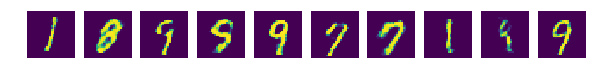

In [12]:
sample_size = 10
noise = get_noise(sample_size, size_of_noise)
samples = sess.run(G, feed_dict={Z: noise})

fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

for i in range(sample_size):
    ax[i].set_axis_off()
    ax[i].imshow(np.reshape(samples[i], (28, 28)))